## Grayscale Image Colorization Autoencoder

# Overview

This project presents an Autoencoder model using TensorFlow and Keras for colorizing grayscale images. The model aims to learn how to automatically colorize black and white images, providing an enhanced view of originally monochromatic pictures.


In [ ]:
import os
import tensorflow as tf

# Check for TPU availability and initialize if available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print('TPU not found')
    strategy = tf.distribute.get_strategy()  # Use CPU or GPU if TPU is not available


# Data Preparation

Images are loaded from a specified folder and converted to grayscale using TensorFlow. The data is then split into training and testing sets.


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the image folder
image_folder = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

# Load images and convert them to grayscale
def load_images(directory, size=(128, 128)):
    images_color = []
    images_gray = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_color = img_array / 255.0
        img_gray = tf.image.rgb_to_grayscale(img_color)
        images_color.append(img_color)
        images_gray.append(img_gray)
    return np.array(images_gray), np.array(images_color)

images_gray, images_color = load_images(image_folder)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(images_gray, images_color, test_size=0.2)


# Model Building

An Autoencoder model is built using TensorFlow and Keras. The model consists of two main parts:
- **Encoder**: Reduces dimensions and extracts features from grayscale images.
- **Decoder**: Reconstructs the colored image from the extracted features.

Batch Normalization is utilized to improve training stability and speed.


In [7]:
from tensorflow.keras.layers import Dropout, BatchNormalization

with strategy.scope():
    def build_autoencoder(input_shape):
        input_img = Input(shape=input_shape)

        # Encoder
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        # Decoder
        x = Conv2DTranspose(512, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(256, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adam', loss='mse')

        return autoencoder

    autoencoder = build_autoencoder(X_train.shape[1:])


# Model Training

The model is trained on the specified dataset, using grayscale images as inputs and the original colored images as targets.


In [12]:
autoencoder.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, Y_test)
)

Epoch 1/20
5065/5065 [==============================] - 149s 29ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 2/20
5065/5065 [==============================] - 127s 25ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 3/20
5065/5065 [==============================] - 126s 25ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 4/20
5065/5065 [==============================] - 128s 25ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 5/20
5065/5065 [==============================] - 127s 25ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 6/20
5065/5065 [==============================] - 129s 25ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 7/20
5065/5065 [==============================] - 128s 25ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 8/20
5065/5065 [==============================] - 125s 25ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 9/20
5065/5065 [==============================] - 127s 25ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 10/20
5065/5065 [==============================] 

# Results Display

`matplotlib` is used to display grayscale images, original colored images, and the model-generated colored images.

1267/1267 [==============================] - 21s 12ms/step


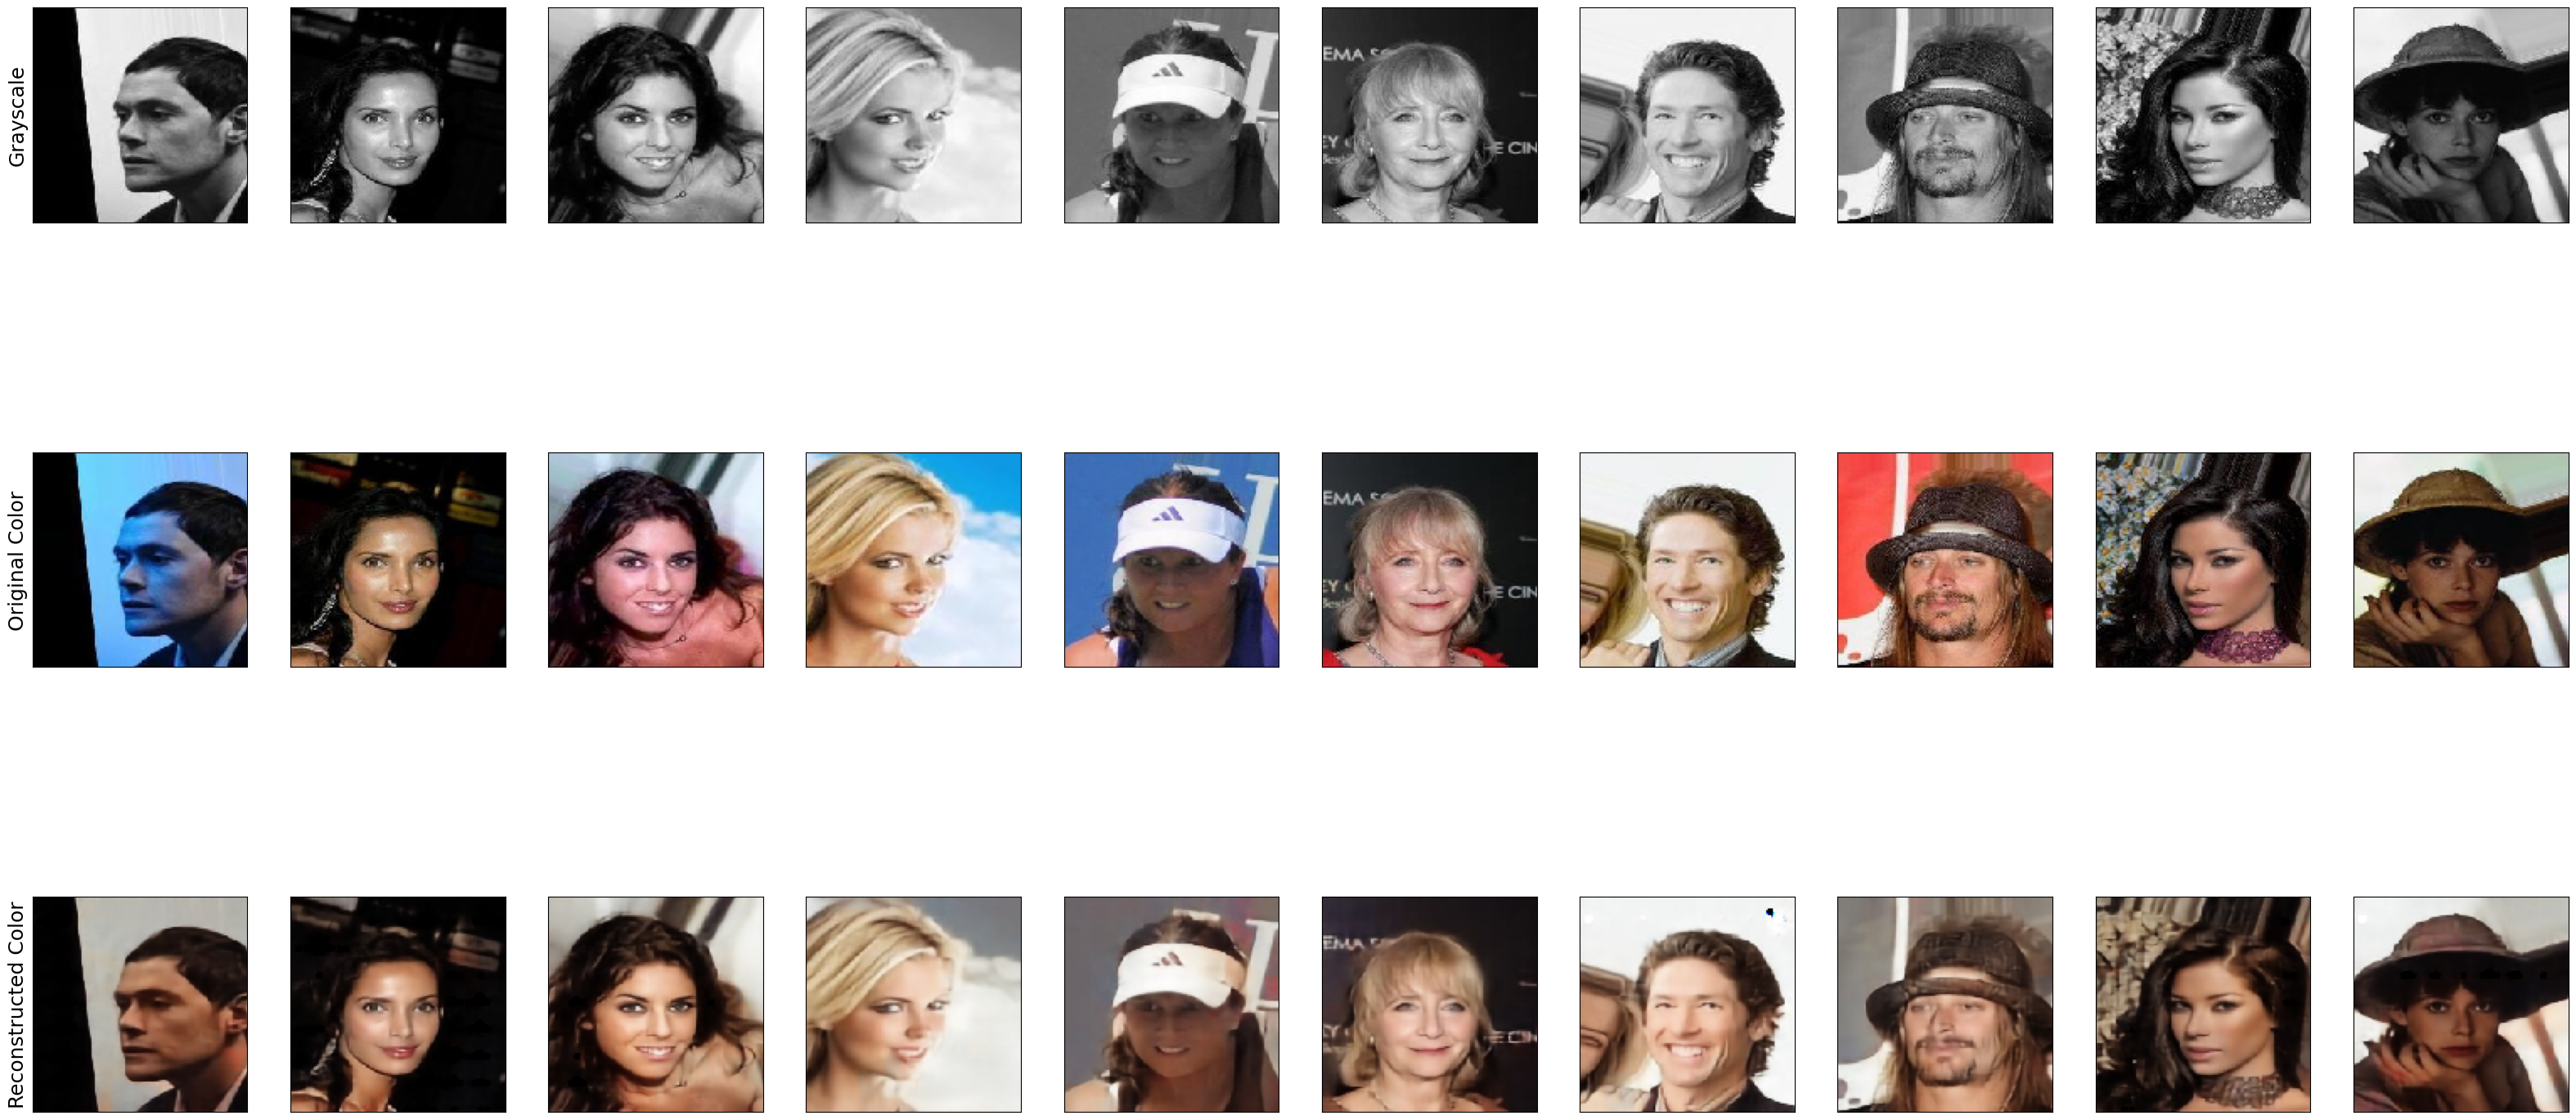

In [13]:
import matplotlib.pyplot as plt

def display_images(original, gray, reconstructed, n=10):
    plt.figure(figsize=(40, 20))  # Increase the figure size for larger display

    for i in range(n):
        # Display grayscale images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(gray[i].reshape(128, 128), cmap='gray')
        plt.xticks([])  # Hide x-axis labels
        plt.yticks([])  # Hide y-axis labels
        if i == 0:
            plt.ylabel('Grayscale', size=18)  # Label for the row

        # Display original colored images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(original[i].reshape(128, 128, 3))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('Original Color', size=18)  # Label for the row

        # Display the reconstructed colored images from the model
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed[i].reshape(128, 128, 3))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('Reconstructed Color', size=18)  # Label for the row

    plt.show()

# Generate colored images from grayscale images in the test set
reconstructed_images = autoencoder.predict(X_test)

# Display the images
display_images(Y_test, X_test, reconstructed_images)
